### This notebook implements Spectral clustering to obtain clusters on a sample dataset `make_moons` from sklearn to demonstrate the algorithm.

#### Next, we will apply spectral clustering to obtain 3 clusters from another dataset and compare the performance of custom implementation of spectral clustering algorithm vs the implementation from sklearn.

#### Spectral Clustering

1. The clustering problem is formulated as a Graph partitioning problem to partition vertices into disjoints sets. The graph is partitioned such that the edges within the groups have high weights (points within clusters are similar) and the edges between groups have small weights (points in different clusters are dissimilar to each other).
The objective function is the total edge weights connecting the partitions and is the criterion for minimization. 
2. Approximate solution to the graph cutting problem is found using generalized eigen value solving problem.
3. The resulting representations of points associated with graph partitions are easily detectable by subsequent clustering algorithms like K-means
4. The data is represented by undirected weighted graph.

### Objective function to minimize
If a cut of graph is - 

$Cut(V1,V2) = \sum_{i \in V_1, j \in V_2} W_{ij} $

The objective function is the normalized graph cut (For eg. To obtain a bipartition)

$ NCut(V1,V2) = \frac{Cut(V_1, V_2)}{Vol(V_1)} + \frac{Cut(V_1, V_2)}{Vol(V_2)}$

$Vol(V_i) = \sum_{i \in V_i} d_i$

Vol(V) sums the weights of all edges for all vertices in partition V.

The minimization problem of $NCut(V_1, V_2)$ can re-expressed as Rayleigh's quotient. Let x be an N dimensional indicator vector where $x_i = 1$ if the graph node i is in $V_1$ and 0 otherwise.


$min_x Ncut(x) = min_y \frac{y^T(D-W)y}{y^Ty}$

subject to one of the conditions $y^TD1=0$ 

where $y$ is also subject to constraints as that of our indicator vector $x$.

For a real symmetric matrix, the Rayleigh's quotient's minimum is obtained by the smallest eigen value and this minimum can be obtained by generalized eigen value system

$(D-W)y = \lambda Dy$

Converting this to a standard eigen system we get,

$D^{-1/2}LD^{-1/2}z = \lambda z$

$z = D^{1/2}y$

The generalized eigen vectors we get are exactly equal to the eigen vectors we can get from Normalized Graph Laplacian and multiplied by $D^{1/2}$

Normalized symmetric Graph Laplacian - $D^{-1/2}LD^{-1/2}$

Here, the solution is, first K eigen vectors of the Normal Laplacian (Symmetric), where K is the number of clusters we are trying to find in the data.
Also, our Laplacian matrix (Normalized or not) is a symmetrix, positive semi-definite matrix i.e its minimum eigen value is 0 and its corresponding eigen vector is called the smallest eigen vector.

**How are the resulting eigen vectors useful for clustering? What information about clusters do they hold within?**


 According to the properties of Rayleigh's quotient for real symmatric matrices, after 0, the next smallest eigen value  and so its corresponding eigen vector is our approximate solution for obtaining a bipartition of the graph and can be extened to use its next smallest eigen vector to further subpartition the first two parts and so on.

 $y$ takes similar real values at nodes i and j which have more similarity ($W_ij$). 

 Though in ideal case y would take only 2 discrete values to partition the graph into two, with the signs indicating belonging of a value to one of the 2 partitions, we obtain continuous values for y and use a splitting point to partition the values in the eigen vector to either of the partitions. I have used 0 as the splitting point.

### Algorithm

1. Define symmetric similarity matrix $W$ for graph having data points as vertices and similarity as edge weights.

$W_{ij} = \exp{\frac{-d(x1,x2)^2}{2\sigma ^2}}$

2. Generate Normalized Symmetric Graph Laplacian as - 

$L_{sym} = D^{-1/2}LD^{-1/2}$

where,
D = Degree matrix
$D = Diag(d_1, d_2, ...,d_n)$

A diagonal matrix containing sum of edge weights for each vertex on the diagonals.

$d_i = \sum_{k=1}^N W_{ik}$

3. Compute the first K smallest eigen vectors of L, where k=No. of clusters in the graph.
4. Take new representations $y_i \in R^k$ and perform clustering on the matrix containing the above eigen vectors.
5. Map the indices of original data points to the indices of the matrix above to label the original data points with the cluster labels obtained for the above matrix.



In [ ]:
! pip install primme

     |████████████████████████████████| 542kB 2.8MB/s 
  Created wheel for primme: filename=primme-3.1.0-cp36-cp36m-linux_x86_64.whl size=5018667 sha256=8c76f1aa895123b1a7146779fbbc2ab0f67061e75623c827f5760bd38933cc34
  Stored in directory: /root/.cache/pip/wheels/0d/34/73/19b45b81fa15f331f21a4e5bf96ff663812d06af7e36e85f01
Successfully built primme


In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score,silhouette_score
from scipy import sparse
import networkx as nx
import primme

random_state = 213
np.random.seed(random_state)

In [ ]:
data_size = 150
x,y = make_moons(n_samples=data_size, noise=0.07, random_state=213)
x.shape, y.shape

((150, 2), (150,))

### True dataset

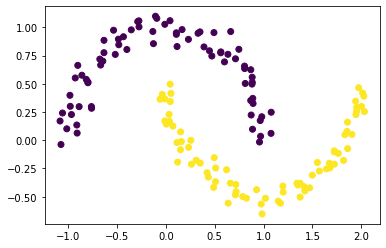

In [ ]:
plt.scatter(x[:,0], x[:,1], c=y.astype(float))
plt.show()

### Using KMeans

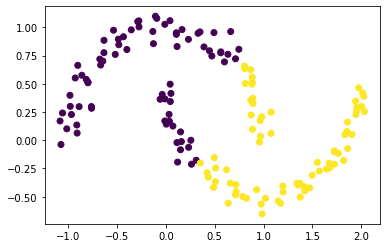

In [ ]:
num_clusters = 2
labels = KMeans(n_clusters=num_clusters, random_state=random_state, n_jobs=6).fit_predict(x)
plt.scatter(x[:,0], x[:,1], c=labels.astype(float))
plt.show()

Given ground truth, we can measure homogeneity, completeness score and v-measure

In [ ]:
# Silhoutte score
silhouette_score(x, labels)

0.48629753345742427

In [ ]:
homogeneity_score(y, labels), completeness_score(y, labels), v_measure_score(y, labels)

(0.1836464702880451, 0.1837407327840609, 0.18369358944333708)

### Using Spectral Clustering
#### Steps

1. Construct a sparse k-nearest similarity graph treating data points as lying in a Euclidean space.

set k = log(N)

Ensure that the resulting graph has single/fewer connected components than or equal to No. of clusters we want.

2. Construct a Normalize Graph Laplacian and obtain eigen values and vectors of the Laplacian.

3. Use the first smallest non-zero eigen value's corresponding eigen vector and set a threshold of 0 to partition rows with values < 0 as belonging to a cluster and those >= 0 as  belonging to the other cluster.

4. Plot the results

#### 1. Creating affinity graph
Obtain affinity graph matrix based on Euclidean distance. The function `kneighbors_graph` below returns a sparse representation for the affinity matrix. It computes distance between every pair of data points and creates and edge from a point to its k neighbors closest to it.

It sets the value to 1 to indicate presence of an edge and 0 otherwise in connectivity mode. In distance mode, it sets the edge weight as the distance between the vertices for k-neighbors and 0 for vertices farther from them. Both modes work fine in this case.

Sparse representation is advantageous for faster computation.

Hyperparameter k for nearest neighbors: 10


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


No. of connected components: 1


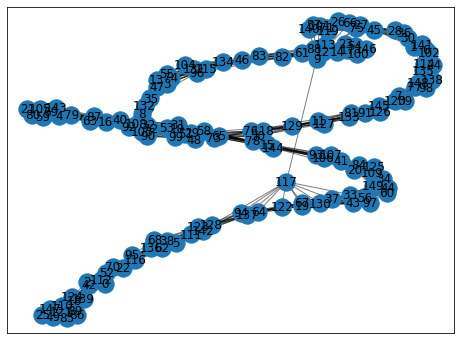

In [ ]:
# Choosing k such that the resulting graph has a single connected component
neighbor_k = 10                                      
sigma = 1 
print("Hyperparameter k for nearest neighbors: {}".format(neighbor_k))

knn_affinity_matrix = kneighbors_graph(x, n_neighbors=neighbor_k, metric='euclidean', mode='distance', n_jobs=6)

# Initialize a sparse similarity graph
similarity_graph = sparse.csr_matrix(knn_affinity_matrix.shape)

# Capture the unordered indices of k nearest neighbors i.e all non zero indices from the affinity matrix
nzeroindices = knn_affinity_matrix.nonzero()

# Convert distance into similarity measure using Gaussian function with width sigma
similarity_graph[nzeroindices] = np.exp(-np.asarray(knn_affinity_matrix[nzeroindices])**2 / 2.0 * sigma**2)

# Making the similarity matrix symmetric. This operation is significantly faster in sparse form of similarity matrix
similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)

knn_graph = nx.from_scipy_sparse_matrix(similarity_graph)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(knn_graph)
nx.draw_networkx_nodes(knn_graph, pos)
nx.draw_networkx_labels(knn_graph, pos)
nx.draw_networkx_edges(knn_graph, pos, width=1.0, alpha=0.5)

print('No. of connected components: {}'.format(nx.number_connected_components(knn_graph)))

2. Construct Normalized Graph Laplacian


In [ ]:
# Obtain the Normalized Graph symmetric Laplacian 
L_sym = sparse.csgraph.laplacian(similarity_graph, normed=True)
e,v = np.linalg.eig(L_sym.todense())

# Multiplicity of eigen values
rounded_e = e.round(5)
print("Multiplicity of 0 eigen values: {} \n".format(rounded_e[rounded_e == 0.0].shape[0]))

# Index of 0 eigen value
index = np.argmin(e)
print("Index of 0 eigen value {} \n".format(index))

# Its corresponding eigen vector with constant eigen values
print("Corresponding eigen vector {}".format(v[:,index][:5]))

# Indices of K smallest eigen values. K = No. of clusters
first_k_indices = np.argpartition(e, kth=num_clusters)[:num_clusters]

# Get smallest non-zero eigen value's index for obtaining partition to cluster
fiedler_index = first_k_indices[1]
fiedler_index

Multiplicity of 0 eigen values: 1 

Index of 0 eigen value 0 

Corresponding eigen vector [[0.08182   ]
 [0.08165317]
 [0.07980088]
 [0.08387569]
 [0.08377827]]


1

In [ ]:
e.shape, v.shape

((150,), (150, 150))

3. Use Fiedler vector to partition data points

The Fiedler vector is the eigen vector corresponding to smallest non-zero eigen value. Indices of values below 0 are assigned to cluster 1 and the indices of rest of them are assigned to cluster 2. 

We are able to use this vector this way because this normalized eigen vector is a scaled version of the indicator vector. An indicator vector is associated with every non-zero eigen value of a matrix. Each indicator vector is also orthogonal to each other and ideally conatains binary values 0 or 1 to indicate cluster membership.

In this case, instead of indicator vector containing 0's and 1's, we have signed continuous values.

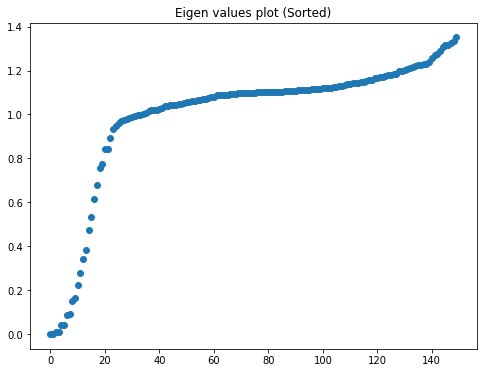

In [ ]:
# The eigen values of Normalized Laplacian are between 0 and 2
# Plotting eigen values
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), np.sort(e))
plt.title("Eigen values plot (Sorted)")
plt.show()

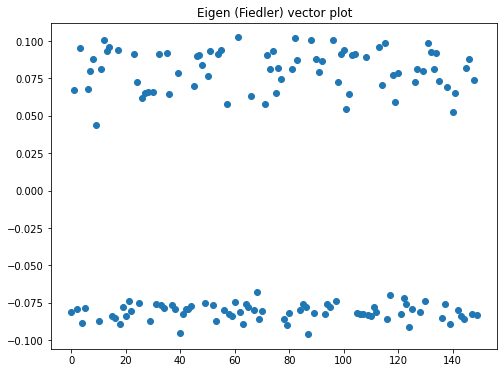

In [ ]:
# The eigen vector for smallest non-zero eigen value i.e plotting the Fiedler vector
# Plotting eigen values
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), v[:,fiedler_index].tolist())
plt.title("Eigen (Fiedler) vector plot")
plt.show()

fiedler_vector = v[:,fiedler_index].copy()

# Thresholding the values in this eigen vector at 0
fiedler_vector[fiedler_vector < 0.0] = 0
fiedler_vector[fiedler_vector > 0.0] = 1

new_labels = np.asarray(fiedler_vector)[:,0]

4. Results


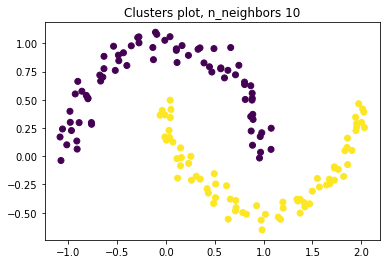

In [ ]:
plt.scatter(x[:,0], x[:,1], c=new_labels.astype(float))
plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
plt.show()

In [ ]:
# Silhoutte score
silhouette_score(fiedler_vector, new_labels)

1.0

In [ ]:
# Homogeneity, completeness score and v-measure for custom spectral clustering algorithm
homogeneity_score(y, new_labels), completeness_score(y, new_labels), v_measure_score(y, new_labels)

(1.0, 1.0, 1.0)

#### Finding K from elbow method using First K eigen vectors

Obtained costs for K in 0.005222868919372558 minutes


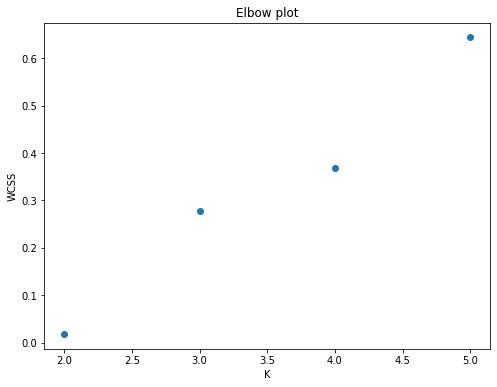

In [ ]:
start_time = time()
distortions = []

for i in range(2,6):
  # indices of first k eigen values
  first_k_eigen_id = np.argpartition(e, kth=i)[:i]

  model = KMeans(n_clusters=i, random_state=random_state, n_jobs=8).fit(v[:, first_k_eigen_id])
  distortions.append(model.inertia_)

print("Obtained costs for K in {} minutes".format((time() - start_time)/60))

plt.figure(figsize=(8,6))
plt.scatter(range(2,6), distortions)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.title("Elbow plot")
plt.show()

Thus, at k=2, we get the minimum value for cost function as used above.

#### Finding k using eigen gap heuristic

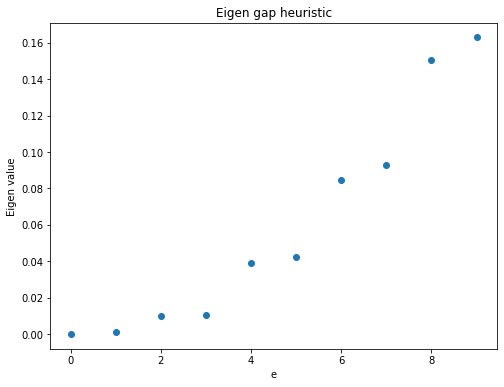

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(10), np.sort(e)[:10])
plt.xlabel("e")
plt.ylabel("Eigen value")
plt.title("Eigen gap heuristic")
plt.show()

From the above plot, the first 2 eigen values are approximately 0 and the gap between the 3rd and the 4th eigen values is larger. Thus, we can say that this representation of data containing first K eigen vectors have 3 clusters.

#### What if K for nearest neighbors is smaller than the optimal value?

In [ ]:
def performSpectralClustering(x, num_clusters, n_neighbors=5):
  neighbor_k = n_neighbors
  sigma = 1 
  print("Hyperparameter k for nearest neighbors: {}".format(neighbor_k))

  knn_affinity_matrix = kneighbors_graph(x, n_neighbors=neighbor_k, metric='euclidean', mode='distance', n_jobs=6)
  similarity_graph = sparse.csr_matrix(knn_affinity_matrix.shape)
  nzeroindices = knn_affinity_matrix.nonzero()
  similarity_graph[nzeroindices] = np.exp(-np.asarray(knn_affinity_matrix[nzeroindices])**2 / 2.0 * sigma**2)
  similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)

  knn_graph = nx.from_scipy_sparse_matrix(similarity_graph)

  plt.figure(figsize=(8,6))
  pos = nx.spring_layout(knn_graph)
  nx.draw_networkx_nodes(knn_graph, pos)
  nx.draw_networkx_labels(knn_graph, pos)
  nx.draw_networkx_edges(knn_graph, pos, width=1.0, alpha=0.5)
  print('No. of connected components: {}'.format(nx.number_connected_components(knn_graph)))

  L_sym = sparse.csgraph.laplacian(similarity_graph, normed=True)
  e,v = np.linalg.eig(L_sym.todense())

  rounded_e = e.round(5)
  print("Multiplicity of 0 eigen values: {} \n".format(rounded_e[rounded_e == 0.0].shape[0]))
  index = np.argmin(e)
  print("Index of 0 eigen value {} \n".format(index))
  print("Corresponding eigen vector {}".format(v[:,index][:5]))

  first_k_indices = np.argpartition(e, kth=num_clusters)[:num_clusters]
  fiedler_index = first_k_indices[1]
  print(fiedler_index)

  plt.figure(figsize=(8,6))
  plt.scatter(np.arange(data_size), np.sort(e))
  plt.title("Eigen values plot (Sorted)")
  plt.show()

  plt.figure(figsize=(8,6))
  plt.scatter(np.arange(data_size), v[:,fiedler_index].tolist())
  plt.title("Eigen (Fiedler) vector plot")
  plt.show()

  fiedler_vector = v[:,fiedler_index].copy()
  fiedler_vector[fiedler_vector < 0.0] = 0
  fiedler_vector[fiedler_vector > 0.0] = 1
  new_labels = np.asarray(fiedler_vector)[:,0]
  plt.scatter(x[:,0], x[:,1], c=new_labels.astype(float))
  plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
  plt.show()

Hyperparameter k for nearest neighbors: 3


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


No. of connected components: 4
Multiplicity of 0 eigen values: 4 

Index of 0 eigen value 54 

Corresponding eigen vector [[0.00166936]
 [0.00867888]
 [0.00183013]
 [0.01228479]
 [0.03412997]]
33


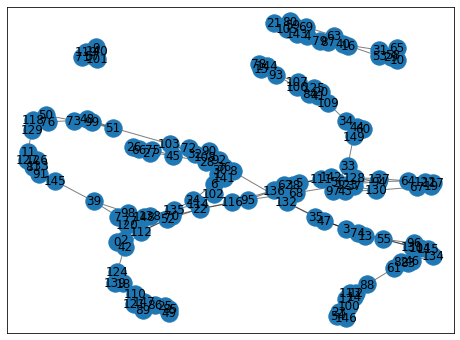

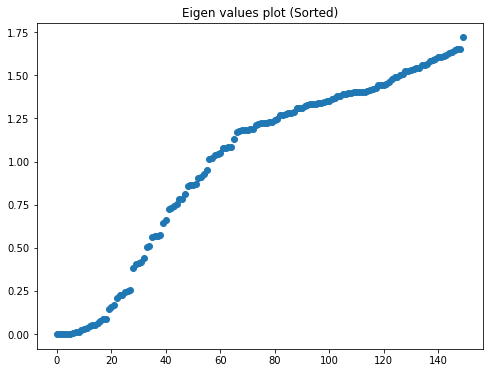

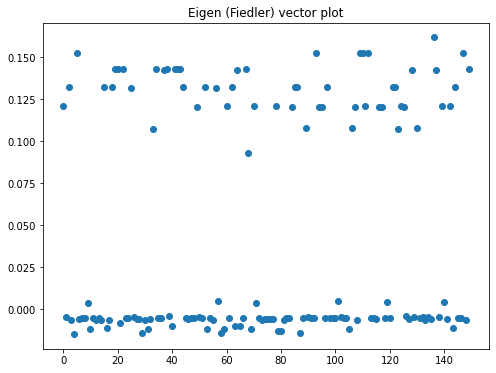

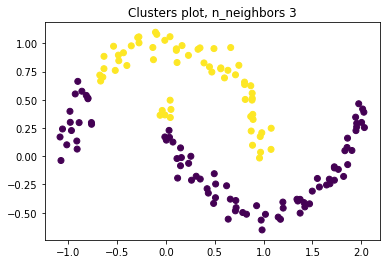

In [ ]:
performSpectralClustering(x, 2, n_neighbors=3)

Thus, the results are obtained well only when the no. of connected components in the similarity graph are fewer than the specified no. of clusters or we only have a single connected component.

### Using Spectral clustering from sklearn

In [ ]:
spectral_clustering_model = SpectralClustering(n_clusters=2,
                                               affinity='nearest_neighbors',
                                               n_neighbors=10, 
                                               random_state=random_state,
                                               n_jobs=8).fit(x)

spectral_c_labels = spectral_clustering_model.fit_predict(x)

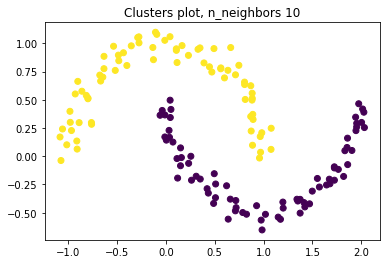

In [ ]:
plt.scatter(x[:,0], x[:,1], c=spectral_c_labels.astype(float))
plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
plt.show()

In [ ]:
# Can also use your own computed affinity matrix - similarity graph and feed it to the Spectral Clustering algorithm
spectral_clustering_model_v2 = SpectralClustering(n_clusters=2,
                                               affinity='precomputed',
                                               n_neighbors=10, 
                                               random_state=random_state,
                                               n_jobs=8).fit(similarity_graph)

spectral_c_labels_v2 = spectral_clustering_model_v2.fit_predict(similarity_graph)

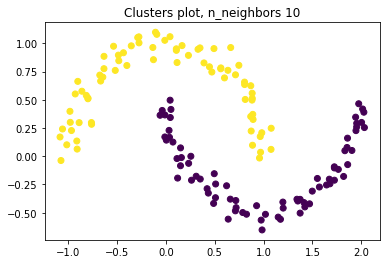

In [ ]:
plt.scatter(x[:,0], x[:,1], c=spectral_c_labels_v2.astype(float))
plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
plt.show()

#### Difference between affinity graph of Spectral clustering and that created by kneighbors_graph function of sklearn

The affinity matrix created by Spectral clustering inbuilt also considers the connectivity from a vertex to itself and hence has affinity of n_neighbors - 1 is included whereas the `kneighbors_graph` includeds connectivity or distance of n_neighbors excluding itself.

Notice, for K=10, the 2 arrays are identical at 9 locations but one in each.
The bitwise XOR operation proves it.

In [ ]:
k_affinity = kneighbors_graph(x,n_neighbors=10, mode='connectivity',metric='euclidean', n_jobs=6)
k_affinity.todense()[0]

matrix([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])

In [ ]:
spectral_clustering_model.affinity_matrix_.todense()[0]

matrix([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])

In [ ]:
np.bitwise_xor(spectral_clustering_model.affinity_matrix_.todense()[0].astype(int), k_affinity.todense()[0].astype(int))

matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

In [ ]:
# No. of places mis-matching in total
np.bitwise_xor(spectral_clustering_model.affinity_matrix_.todense()[0].astype(int), k_affinity.todense()[0].astype(int)).sum()

2

Hence, using the **same value of n_neighbors** might result in different affinity matrices from different approaches of creation and may result in more no. of connected components in case of the graph created from Spectral clustering's affinity matrix than otherwise and hence, poorer results as compared to results from using `kneighbors_graph`.


### Comparing results & performance of custom implementation and sklearn's one using different dataset

In [ ]:
data_size = 1500
random_state = 170
np.random.seed(random_state)
blob_x, blob_y = make_blobs(n_samples=data_size, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
blob_x = np.dot(blob_x, transformation)

In [ ]:
blob_x.shape, blob_y.shape

((1500, 2), (1500,))

### True clusters

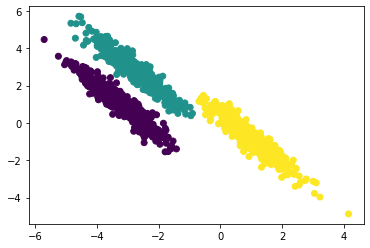

In [ ]:
plt.scatter(blob_x[:,0], blob_x[:,1], c=blob_y.astype(float))
plt.show()

### Using KMeans


In [ ]:
num_clusters = 3
kmeans_model = KMeans(n_clusters=num_clusters, random_state=random_state, n_jobs=6).fit(blob_x)
blob_kmeans_labels = kmeans_model.predict(blob_x)
centers = kmeans_model.cluster_centers_

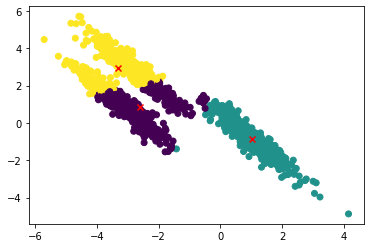

In [ ]:
plt.scatter(blob_x[:,0], blob_x[:,1], c=blob_kmeans_labels.astype(float), marker='o')
plt.scatter(centers[:,0], centers[:,1], c=['r'], marker='x')
plt.show()

In [ ]:
print("Silhouette score {}".format(silhouette_score(blob_x, blob_kmeans_labels)))

print("homogeneity score {},\n completeness score {},\n v_measure_score {}".format(homogeneity_score(blob_y, blob_kmeans_labels), 
                                                                                 completeness_score(blob_y, blob_kmeans_labels), 
                                                                                 v_measure_score(blob_y, blob_kmeans_labels)))
  

Silhouette score 0.5090693051040507
homogeneity score 0.627064408110481,
 completeness score 0.6272490895883972,
 v_measure_score 0.6271567352534567


### Updating custom spectral clustering to work on more than 2 clusters and larger data.

We can use an efficient eigen solver PRIMME (Pre-conditioned Iterative Multimethod Solver ), optimized for large scale eigen systems. We will use it to solve a standard eigen value problem $Ax = \lambda x$ where A will be our Real symmetric Normalized Laplacian Matrix.

**How does it make this solution faster?**

The Eigen values of a Normalized Laplacian are between 0 and 2. Hence, the eigen values for I - L will be between -1 and 1.

Hence, we will specify the solver to look for only k (k - No. of cluster) eigen values closer to 1.0 by setting the value of its parameter sigma as 1.0 and find the smallest magnitude eigen values closer to sigma.

Next, we can replace the step of using Fiedler vector and setting a splitting value and instead apply K-means algorithm on the first smallest k eigen vectors.

In [ ]:
def performSpectralClustering(x, num_clusters, n_neighbors=5):
  neighbor_k = n_neighbors
  sigma = 1 
  print("Hyperparameter k for nearest neighbors: {}".format(neighbor_k))

  knn_affinity_matrix = kneighbors_graph(x, n_neighbors=neighbor_k, metric='euclidean', mode='distance', n_jobs=6)
  similarity_graph = sparse.csr_matrix(knn_affinity_matrix.shape)
  nzeroindices = knn_affinity_matrix.nonzero()
  similarity_graph[nzeroindices] = np.exp(-np.asarray(knn_affinity_matrix[nzeroindices])**2 / 2.0 * sigma**2)
  similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)

  L_sym, dd = sparse.csgraph.laplacian(similarity_graph, normed=True, return_diag=True)
  e, evecs = primme.eigsh(A=L_sym, k=num_clusters, sigma=1.0, which='LM')
  print("Eigen values i.e graph min cuts {}".format(e))
  # Row normalization
  v = (evecs.T / dd).T
  first_k_eigen_id = np.argsort(e)[:num_clusters]

  kmeans_model = KMeans(n_clusters=num_clusters, 
                        random_state=random_state,
                        n_jobs=6).fit(v[:, first_k_eigen_id])
  new_labels = kmeans_model.predict(v[:, first_k_eigen_id])
  centers = kmeans_model.cluster_centers_
  indicator_vector = v[:, first_k_eigen_id]
  plt.scatter(x[:,0], x[:,1], c=new_labels.astype(float), marker='o')
  plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
  plt.show()

  # Silhoutte score
  print("Silhouette score {}".format(silhouette_score(indicator_vector, new_labels)))

  print("homogeneity score {},\n completeness score {},\n v_measure_score {}".format(homogeneity_score(blob_y, new_labels), 
                                                                                 completeness_score(blob_y, new_labels), 
                                                                                 v_measure_score(blob_y, new_labels)))
  return similarity_graph

Hyperparameter k for nearest neighbors: 10


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Eigen values i.e graph min cuts [2.28334491e-16 1.19387930e-04 4.37354985e-04]


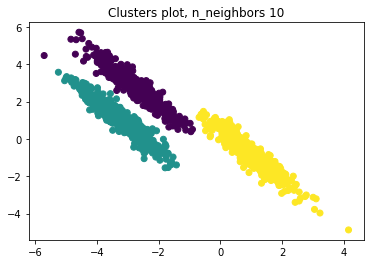

Silhouette score 0.8302198743642923
homogeneity score 0.995621380714046,
 completeness score 0.995622589054499,
 v_measure_score 0.9956219848839059


In [ ]:
similarity_graph = performSpectralClustering(blob_x, 3, n_neighbors=10)

### Comparison with Sklearn spectral clustering

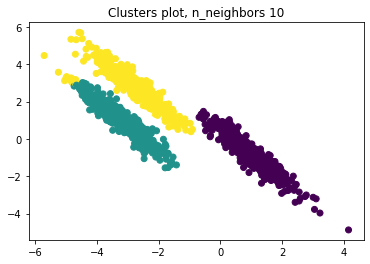

In [ ]:
spectral_clustering_model = SpectralClustering(n_clusters=3,
                                               affinity='nearest_neighbors',
                                               n_neighbors=10,
                                               random_state=random_state).fit(blob_x)
spectral_c_labels = spectral_clustering_model.fit_predict(blob_x)

plt.scatter(blob_x[:,0], blob_x[:,1], c=spectral_c_labels.astype(float))
plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
plt.show()


In [ ]:
print("homogeneity score {},\n completeness score {}, \n v_measure_score {}".format(homogeneity_score(blob_y, spectral_c_labels), 
                                                                                 completeness_score(blob_y, spectral_c_labels), 
                                                                                 v_measure_score(blob_y, spectral_c_labels)))


homogeneity score 0.9632183750720691,
 completeness score 0.9634160009374547, 
 v_measure_score 0.9633171778689563


In [ ]:
## Affinity matrix
spectral_clustering_model.affinity_matrix_.todense()[:10]

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

#### Using our own similarity graph than the unweighted adjacency matrix generated by `SpectralClustering` class


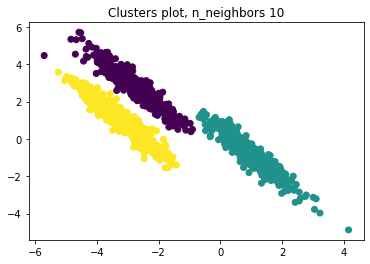

In [ ]:
spectral_clustering_model_v2 = SpectralClustering(n_clusters=3,
                                               affinity='precomputed',
                                               n_neighbors=10,
                                               random_state=random_state).fit(similarity_graph)
spectral_c_labels_v2 = spectral_clustering_model_v2.fit_predict(similarity_graph)

plt.scatter(blob_x[:,0], blob_x[:,1], c=spectral_c_labels_v2.astype(float))
plt.title("Clusters plot, n_neighbors {}".format(neighbor_k))
plt.show()


In [ ]:
print("homogeneity score {},\n completeness score {}, \n v_measure_score {}".format(homogeneity_score(blob_y, spectral_c_labels_v2), 
                                                                                 completeness_score(blob_y, spectral_c_labels_v2), 
                                                                                 v_measure_score(blob_y, spectral_c_labels_v2)))


homogeneity score 0.995621380714046,
 completeness score 0.995622589054499, 
 v_measure_score 0.9956219848839059


In [ ]:
similarity_graph[similarity_graph.nonzero()]

matrix([[0.99948251, 0.99318081, 0.99971491, ..., 0.49840869, 0.99791315,
         0.99820348]])

For this data set, the custom weighted k-nearest neighbors graph representation obtains better results than the connectivity based unweighted k-nearest neighbors affinity matrix built by Spectral Clustering by sklearn

### References
* http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf
* https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf
* http://www.cs.wm.edu/~andreas/software/doc/intro.html
* http://www.cs.wm.edu/~andreas/publications/primmeTOMS.pdf
* https://github.com/scikit-learn/scikit-learn/blob/fd237278e895b42abe8d8d09105cbb82dc2cbba7/sklearn/manifold/_spectral_embedding.py#L137
* http://researchers.lille.inria.fr/~valko/projects/courses/graphsML/20162017/mlgraphs2.pdf


